In [1]:
import os 
import pandas as pd 
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from Code_manual import Coxnnet, PartialNLL
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.getcwd()

'd:\\Survival Analysis\\Cox-nnet'

Load KIRC data

In [3]:
expr_data = pd.read_table("./KIRC_expr.tsv", header=None)

time_data = pd.read_table("./KIRC_time.tsv", header=None)

observed_data = pd.read_table("./KIRC_event.tsv", header=None)

map_dict = {'DECEASED' : 1,
            'LIVING' : 0}
observed_data = observed_data[0].apply(lambda x : map_dict[x])

In [4]:
X = torch.tensor(np.array(expr_data), dtype=torch.float)
time = torch.tensor(time_data.to_numpy(), dtype=torch.long)
observed = torch.tensor(observed_data.to_numpy(), dtype=torch.float)

train_idx, test_idx, _, _ = train_test_split(np.arange(X.shape[0]), observed, test_size=0.3, random_state=42)

train_X = X[train_idx,:]
test_X = X[test_idx,:]

train_time = time[train_idx]
test_time = time[test_idx]

train_observed = observed[train_idx]
test_observed = observed[test_idx]

In [5]:
cuda = True if torch.cuda.is_available() else False
if cuda:
    device = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')

Train & Test

In [6]:
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

class TrainDataset(Dataset):
    def __init__(self):
        self.x_data = torch.tensor(train_X, device=device)
        self.time_data = torch.tensor(train_time, device=device)
        self.observed_data = torch.tensor(train_observed, device=device)
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, index):
        x = torch.tensor(self.x_data[index]).clone().detach()
        time = torch.tensor(self.time_data[index]).clone().detach()
        observed = torch.tensor(self.observed_data[index]).clone().detach()
        return x, time, observed
    
class TestDataset(Dataset):
    def __init__(self):
        self.x_data = torch.tensor(test_X, device=device)
        self.time_data = torch.tensor(test_time, device=device)
        self.observed_data = torch.tensor(test_observed, device=device)
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, index):
        x = torch.tensor(self.x_data[index]).clone().detach()
        time = torch.tensor(self.time_data[index]).clone().detach()
        observed = torch.tensor(self.observed_data[index]).clone().detach()
        return x, time, observed
    
training_data = TrainDataset()
test_data = TestDataset()

train_dataloader = DataLoader(training_data, batch_size = training_data.__len__())
test_dataloader = DataLoader(test_data, batch_size = test_data.__len__())

In [7]:
acc = []

hidden_dim = 500
model = Coxnnet(train_X.shape[1], hidden_dim)
model = model.to(device)
learning_rate = 5e-5
epochs = 137

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = PartialNLL()

def train_loop(dataloader, model, loss_fn, optimizer, t):
    size = len(dataloader.dataset)
    for batch, (X, time, observed) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, time, observed)

        # Backpropagation
        optimizer.zero_grad()   # bc/ gradients by default add up; to prevent double counting.
        loss.backward() # deposits gradients
        optimizer.step()    # adjust parameters with gradients
        
        train_perf = 0
        train_perf = concordance_index(event_times = time.cpu().detach().numpy(),
                                       event_observed = observed.cpu().detach().numpy(),
                                       predicted_scores = -pred.cpu().detach().numpy())    
        
        if ((t+1) % 25 == 0):
            print(f"Epoch {t+1}\n-------------------------------")
            print(f"Train Accuracy: {train_perf}\n")
            print(f"Train Loss: {loss.item()}\n")

# iterate over test dataset to check model performance
def test_loop(dataloader, model, t):
    size = len(dataloader.dataset)
    test_perf = 0

    with torch.no_grad():
        for X, time, observed in dataloader:
            pred = model.forward(X)
            test_perf = concordance_index(event_times = time.cpu().detach().numpy(),
                                          event_observed = observed.cpu().detach().numpy(),
                                          predicted_scores = -pred.cpu().detach().numpy())

    if ((t+1) % 25 == 0):
        print(f"Test Accuracy: {test_perf}\n")
        
    if (t+1 == epochs):
        acc.append(test_perf)

In [8]:
for i in range(10):
    print(f"------------\nReplicate {i+1}\n------------")
    train_idx, test_idx, _, _ = train_test_split(np.arange(X.shape[0]), observed, test_size=0.3, random_state=i)

    train_X = X[train_idx,:]
    test_X = X[test_idx,:]

    train_time = time[train_idx]
    test_time = time[test_idx]

    train_observed = observed[train_idx]
    test_observed = observed[test_idx]
    model = Coxnnet(train_X.shape[1], hidden_dim)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for t in range(epochs):
        model.train()
        train_loop(train_dataloader, model, loss_fn, optimizer, t)
        model.eval()
        test_loop(test_dataloader, model, t)

------------
Replicate 1
------------
Epoch 25
-------------------------------
Train Accuracy: 0.7066998548019083

Train Loss: 5.123104102662653

Test Accuracy: 0.6135759558372521

Epoch 50
-------------------------------
Train Accuracy: 0.7314872433105165

Train Loss: 5.059924014599616

Test Accuracy: 0.6370885299529748

Epoch 75
-------------------------------
Train Accuracy: 0.7894973380349858

Train Loss: 4.83430856379

Test Accuracy: 0.6377019014516458

Epoch 100
-------------------------------
Train Accuracy: 0.7942681324759732

Train Loss: 4.827643644500971

Test Accuracy: 0.6469024739317113

Epoch 125
-------------------------------
Train Accuracy: 0.8162552720735671

Train Loss: 4.846830905730161

Test Accuracy: 0.6399509302801063

------------
Replicate 2
------------
Epoch 25
-------------------------------
Train Accuracy: 0.7144783239991703

Train Loss: 5.086173087410247

Test Accuracy: 0.6571253322428952

Epoch 50
-------------------------------
Train Accuracy: 0.776948074

In [9]:
print(f"acc: {acc}")
print(f"average of acc: {sum(acc)/len(acc)}")

acc: [0.6509916172561848, 0.6610100184011449, 0.6342261296258433, 0.6659169903905132, 0.6603966469024739, 0.6421999591085668, 0.6522183602535269, 0.6601921897362503, 0.6554896749131057, 0.6550807605806583]
average of acc: 0.6537722347168268


In [10]:
KIRC_acc = acc

Load LAML data & train

In [11]:
expr_data = pd.read_table("./LAML_expr.tsv", header=None)

time_data = pd.read_table("./LAML_time.tsv", header=None)

observed_data = pd.read_table("./LAML_event.tsv", header=None)

map_dict = {'DECEASED' : 1,
            'LIVING' : 0}
observed_data = observed_data[0].apply(lambda x : map_dict[x])

In [12]:
acc = []

for i in range(10):
    print(f"------------\nReplicate {i+1}\n------------")
    train_idx, test_idx, _, _ = train_test_split(np.arange(X.shape[0]), observed, test_size=0.3, random_state=i)

    train_X = X[train_idx,:]
    test_X = X[test_idx,:]

    train_time = time[train_idx]
    test_time = time[test_idx]

    train_observed = observed[train_idx]
    test_observed = observed[test_idx]
    model = Coxnnet(train_X.shape[1], hidden_dim)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for t in range(epochs):
        model.train()
        train_loop(train_dataloader, model, loss_fn, optimizer, t)
        model.eval()
        test_loop(test_dataloader, model, t)

------------
Replicate 1
------------
Epoch 25
-------------------------------
Train Accuracy: 0.7393694254304086

Train Loss: 5.000588557581994

Test Accuracy: 0.6190962993252913

Epoch 50
-------------------------------
Train Accuracy: 0.7861785245108207

Train Loss: 4.86554767563081

Test Accuracy: 0.6370885299529748

Epoch 75
-------------------------------
Train Accuracy: 0.7976215169743484

Train Loss: 4.84789568848631

Test Accuracy: 0.6413821304436721

Epoch 100
-------------------------------
Train Accuracy: 0.788978773421835

Train Loss: 4.860504742863773

Test Accuracy: 0.6340216724596197

Epoch 125
-------------------------------
Train Accuracy: 0.801942888750605

Train Loss: 4.784875603853581

Test Accuracy: 0.6558985892455531

------------
Replicate 2
------------
Epoch 25
-------------------------------
Train Accuracy: 0.6949457235704902

Train Loss: 5.1433403482867535

Test Accuracy: 0.5673686362707013

Epoch 50
-------------------------------
Train Accuracy: 0.74683675

In [13]:
LAML_acc = acc

Load PAAD data & train

In [14]:
expr_data = pd.read_table("./PAAD_expr.tsv", header=None)

time_data = pd.read_table("./PAAD_time.tsv", header=None)

observed_data = pd.read_table("./PAAD_event.tsv", header=None)

map_dict = {'DECEASED' : 1,
            'LIVING' : 0}
observed_data = observed_data[0].apply(lambda x : map_dict[x])

In [15]:
acc = []

for i in range(10):
    print(f"------------\nReplicate {i+1}\n------------")
    train_idx, test_idx, _, _ = train_test_split(np.arange(X.shape[0]), observed, test_size=0.3, random_state=i)

    train_X = X[train_idx,:]
    test_X = X[test_idx,:]

    train_time = time[train_idx]
    test_time = time[test_idx]

    train_observed = observed[train_idx]
    test_observed = observed[test_idx]
    model = Coxnnet(train_X.shape[1], hidden_dim)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for t in range(epochs):
        model.train()
        train_loop(train_dataloader, model, loss_fn, optimizer, t)
        model.eval()
        test_loop(test_dataloader, model, t)
        
PAAD_acc = acc

------------
Replicate 1
------------
Epoch 25
-------------------------------
Train Accuracy: 0.6654912535435249

Train Loss: 5.204111841234255

Test Accuracy: 0.6370885299529748

Epoch 50
-------------------------------
Train Accuracy: 0.7365691765193944

Train Loss: 5.095965579928198

Test Accuracy: 0.6493559599263954

Epoch 75
-------------------------------
Train Accuracy: 0.7725921316462698

Train Loss: 4.8960795436273115

Test Accuracy: 0.6469024739317113

Epoch 100
-------------------------------
Train Accuracy: 0.7553066445412432

Train Loss: 4.913933476345916

Test Accuracy: 0.6520139030873032

Epoch 125
-------------------------------
Train Accuracy: 0.7924012998686303

Train Loss: 4.8185248952982

Test Accuracy: 0.6661214475567369

------------
Replicate 2
------------
Epoch 25
-------------------------------
Train Accuracy: 0.7251953260042868

Train Loss: 5.107308285012397

Test Accuracy: 0.6342261296258433

Epoch 50
-------------------------------
Train Accuracy: 0.772834

Average of accuracy per data

In [16]:
print(f"Average of KIRC acc : {sum(KIRC_acc)/len(KIRC_acc)}")
print(f"Average of LAML acc : {sum(LAML_acc)/len(LAML_acc)}")
print(f"Average of PAAD acc : {sum(PAAD_acc)/len(PAAD_acc)}")

Average of KIRC acc : 0.6537722347168268
Average of LAML acc : 0.6590881210386424
Average of PAAD acc : 0.6649355959926395


Boxplot

<function matplotlib.pyplot.show(close=None, block=None)>

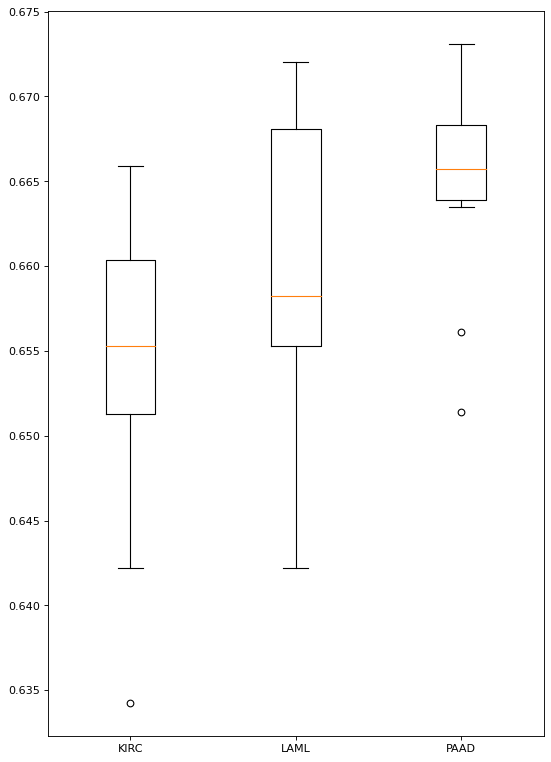

In [17]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 12), dpi=80)

data = [KIRC_acc, LAML_acc, PAAD_acc]
plt.boxplot(data, labels=['KIRC', 'LAML', 'PAAD'])
plt.show